In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import chromadb
from pprint import pprint
import os, sys, json
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

import utils.util as utils
import utils.plot as pt
import utils.script as scr

In [3]:
#../data_files/week_clean_without_comment_labeled/data_python.csv
file_path = "../data_files/reduced/reduced_week6.csv"
data = scr.read_data(file_path)
data.columns

Index(['Unnamed: 0', 'user_id', 'code_content', 'Email', 'label',
       'cluster_labels'],
      dtype='object')

In [4]:
data.head()

,Unnamed: 0,user_id,code_content,Email,label,cluster_labels
0,0,619,pip install python-dotenv\nimport os\nfrom dot...,abrhamaddis32@gmail.com,Intermediate,2
1,1,606,!pip install -qU \\n langchain==0.0.355 \\n ...,abelbekele.addise@gmail.com,Advanced,1
2,2,699,%pip install -qU \\n langchain==0.0.292 \\n ...,natnaelbekele142@gmail.com,Intermediate,1
3,3,652,!import os\nfrom dotenv import load_dotenv\n \...,fanuelabebe@gmail.com,Advanced,2
4,4,688,"from fastapi import FastAPI, HTTPException, Qu...",msganawberihun10@gmail.com,Intermediate,3


In [5]:
samples = data['code_content'].tolist()
embedded_documents = utils.embedding(samples)

In [6]:
chroma_client = chromadb.Client()

In [7]:
# chroma_client.delete_collection(name="test1")

In [8]:

chroma_collection = chroma_client.create_collection("test1", embedding_function=embedded_documents)
ids = [str(i) for i in range(len(samples))]
chroma_collection.add(ids=ids, embeddings=embedded_documents)

In [9]:
collection = chroma_client.get_collection(name="test1")
collection

Collection(name=test1)

In [10]:
# chroma_client.delete_collection(name="test1")

In [11]:
fetched_vector = collection.get(include=['embeddings', 'documents', 'metadatas'])

In [12]:
optimal_k = utils.silhouette_to_find_optimal_k(fetched_vector['embeddings'])
optimal_k

2

In [13]:
cluster_labels, level_embeddings = utils.kmeans_clustering(optimal_k, fetched_vector['embeddings'])
len(cluster_labels)

17

In [14]:
data['cluster_labels'] = cluster_labels
data.head()

,Unnamed: 0,user_id,code_content,Email,label,cluster_labels
0,0,619,pip install python-dotenv\nimport os\nfrom dot...,abrhamaddis32@gmail.com,Intermediate,0
1,1,606,!pip install -qU \\n langchain==0.0.355 \\n ...,abelbekele.addise@gmail.com,Advanced,0
2,2,699,%pip install -qU \\n langchain==0.0.292 \\n ...,natnaelbekele142@gmail.com,Intermediate,0
3,3,652,!import os\nfrom dotenv import load_dotenv\n \...,fanuelabebe@gmail.com,Advanced,0
4,4,688,"from fastapi import FastAPI, HTTPException, Qu...",msganawberihun10@gmail.com,Intermediate,1


In [15]:
#pprint(data['code_content'][0])

In [16]:
data = data.drop('Unnamed: 0', axis=1)

In [17]:
# data.to_csv('../data_files/clustered_data/week7_reduced_clustered.csv', index=True)

In [37]:
import pickle

def Fetch_Each_clustering_Content(optimal_k, texts, cluster_labels, save_path):
    clusters = [[] for _ in range(optimal_k)]  # Create empty list for each cluster

    for text, label in zip(texts, cluster_labels):
        clusters[label].append(text)  # Append text to the corresponding cluster list
    
    with open(save_path, 'wb') as file:
        pickle.dump(clusters, file)
    
    return clusters

In [38]:
texts = data['code_content'].tolist()
save_path = "../txt/pickle/cluster_lists.pkl"  
cluster_contents = Fetch_Each_clustering_Content(optimal_k, texts, cluster_labels, save_path)
print(len(cluster_contents[1]))

3


In [18]:
percentage = pt.calculate_matched_percentages(data, cluster_labels)
percentage

{0: {'Advanced': 23.53, 'Basic': 17.65, 'Intermediate': 41.18},
 1: {'Advanced': 5.88, 'Basic': 5.88, 'Intermediate': 5.88}}

# UMAP Visualization

In [19]:
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

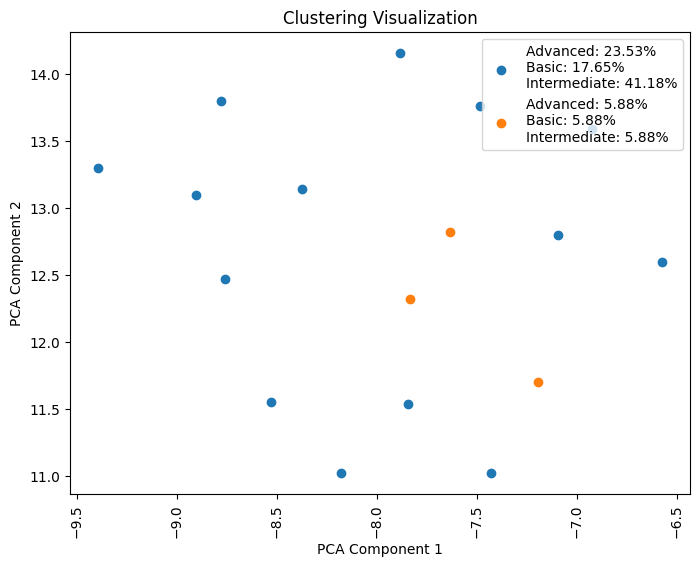

In [22]:
pt.visualize_with_umap_2d(level_embeddings, cluster_labels, data)

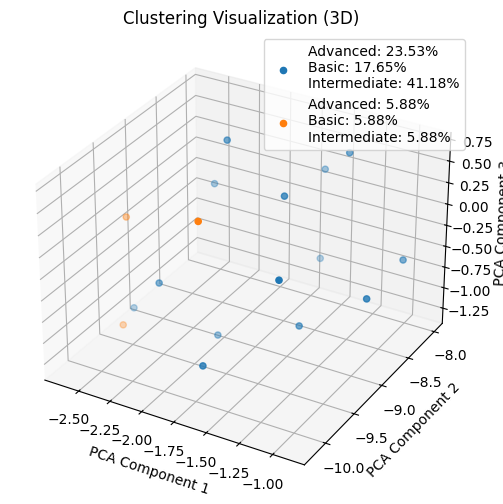

In [23]:
pt.visualize_with_umap_3d(level_embeddings, cluster_labels, data)

# TSNE Visualization

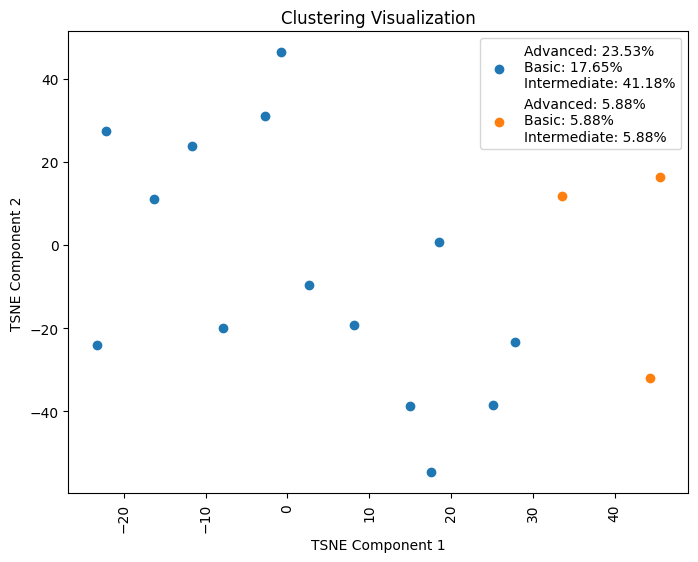

In [24]:
pt.visualize_with_tsne_2d(level_embeddings, cluster_labels, data)

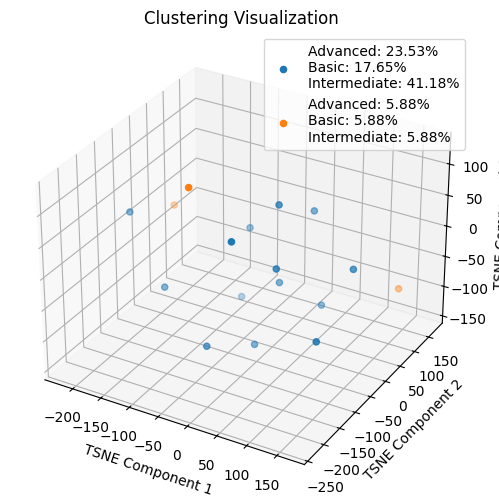

In [25]:
pt.visualize_with_tsne_3d(level_embeddings, cluster_labels, data)

# PCA Visualization

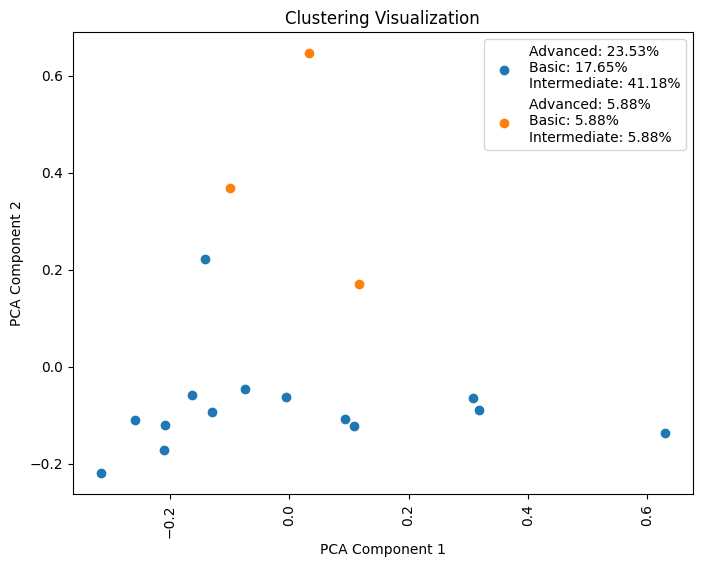

In [26]:
pt.visualize_clusters(level_embeddings, cluster_labels, data)

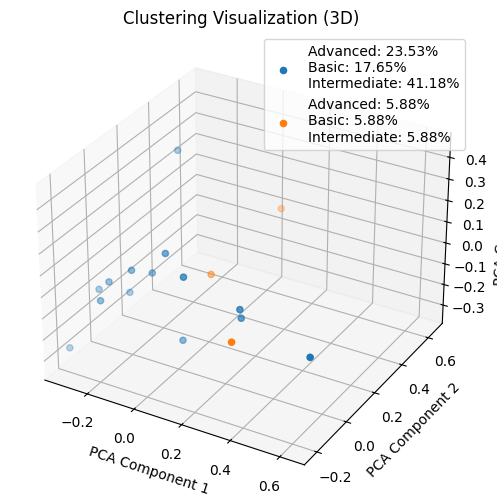

In [27]:
pt.visualize_clusters_3d(level_embeddings, cluster_labels, data)

In [ ]:
# texts = data['code_content'].tolist()
# utils.Fetch_Each_clustering_Content(texts, cluster_labels)